In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from pathlib import Path
import supy as sp
import os
from shutil import copyfile
import geopandas as gpd
import pickle
pd.options.mode.chained_assignment = None
from IPython.display import clear_output

# Necessary functions for analysis

## To read attributes from csv files

In [77]:
def generate_array_dif(attrs_site, attr,level):
    dar = [0.25,0.25,.25]
    dar[level] = attrs_site[attr].values[0]
    return dar


def generate_array_same(attrs_site, attr):
    a = attrs_site[attr].values[0]
    return [a, a, a]

## Modifying `df_state_init` for each land cover

In [78]:
def modify_attr(df_state_init, df, name):

    all_attrs = pd.read_csv('all_attrs.csv')
    attrs_site = all_attrs[all_attrs.site == name]
    df_state_init.loc[:, 'emissionsmethod'] = 0
    df_state_init.loc[:,'roughlenheatmethod']=1
    

    if attrs_site.land.values[0] == 'DecTr':
        ar = [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
        level = 1
        df_state_init.albmin_dectr=attrs_site['albmin'].values[0]
        df_state_init.albmax_dectr=attrs_site['albmax'].values[0]
        df_state_init.albdectr_id=df_state_init.albmin_dectr
        df_state_init.loc[:, 'dectreeh'] = attrs_site.height.values[0]

    elif attrs_site.land.values[0] == 'EveTr':
        ar = [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
        level = 0
        df_state_init.albmin_evetr=attrs_site['albmin'].values[0]
        df_state_init.albmax_evetr=attrs_site['albmax'].values[0]
        df_state_init.albevetr_id=df_state_init.albmin_evetr
        df_state_init.loc[:, 'evetreeh'] = attrs_site.height.values[0]

    elif attrs_site.land.values[0] == 'Grass':
        ar = [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
        level = 2
        df_state_init.albmin_grass=attrs_site['albmin'].values[0]
        df_state_init.albmax_grass=attrs_site['albmax'].values[0]
        df_state_init.loc[:,'roughlenmommethod']=1
        df_state_init.albgrass_id=df_state_init.albmin_grass
        df_state_init.loc[:,'z0m_in']=attrs_site.height.values[0]*.1
        df_state_init.loc[:,'zdm_in']=attrs_site.height.values[0]*.7

    else:
        print('The land cover type is not found! using the default one')

    df_state_init.loc[:, 'sfr'] = ar
    df_state_init.loc[:, 'lat'] = df.Latitude.values[0].values[0]
    df_state_init.loc[:, 'lng'] = df.Longitude.values[0].values[0]
    df_state_init.loc[:, 'z'] = attrs_site.meas.values[0]
    df_state_init.loc[:, 'laimin'] = generate_array_dif(attrs_site, 'laimin',level)
    df_state_init.loc[:, 'laimax'] = generate_array_dif(attrs_site, 'laimax',level)
    df_state_init.loc[:, 'gddfull'] = generate_array_same(attrs_site, 'gddfull')
    df_state_init.loc[:, 'sddfull'] = generate_array_same(attrs_site, 'sddfull')
    df_state_init.loc[:, 'basete'] = generate_array_same(attrs_site, 'basete')
    df_state_init.loc[:, 'baset'] = generate_array_same(attrs_site, 'baset')
    df_state_init.lai_id = df_state_init.loc[:, 'laimin']
    
    

    return df_state_init,level


def func_parse_date(year, doy, hour, min):
    dt = pd.to_datetime(' '.join([str(k) for k in [year, doy, hour, min]]),
                        format='%Y %j %H %M')
    return dt


## Functions to calculate LAI based on the Crop LAI model

In [79]:
def cal_alb_LAI(name,year,lai):
    
    if year==2014:
        date2=datetime.datetime(2014,11,30)
        date2_0=datetime.datetime(2014,12,15)
        date2_1=datetime.datetime(2015,5,1)
        date2_2=datetime.datetime(2015,4,16)
        date2_3=datetime.datetime(2015,5,31)

        date1=datetime.datetime(2014,6,10)
        date1_0=datetime.datetime(2014,6,21)
        date1_1=datetime.datetime(2014,8,5)
        date1_2=datetime.datetime(2014,10,1)
        date1_3=datetime.datetime(2014,11,9)
    
    elif year==2015:
        date2=datetime.datetime(2015,11,30)
        date2_0=datetime.datetime(2015,12,10)
        date2_1=datetime.datetime(2016,5,1)
        date2_2=datetime.datetime(2016,4,17)
        date2_3=datetime.datetime(2016,5,25)

        date1=datetime.datetime(2015,6,10)
        date1_0=datetime.datetime(2015,6,20)    
        date1_1=datetime.datetime(2015,8,10)
        date1_2=datetime.datetime(2015,10,2)
        date1_3=datetime.datetime(2015,11,7)

    elif year==2016:
        date2=datetime.datetime(2016,11,30)
        date2_0=datetime.datetime(2016,12,14)
        date2_1=datetime.datetime(2017,5,1)
        date2_2=datetime.datetime(2017,4,15)
        date2_3=datetime.datetime(2017,5,31)

        date1=datetime.datetime(2016,6,10)
        date1_0=datetime.datetime(2016,6,16)
        date1_1=datetime.datetime(2016,8,6)
        date1_2=datetime.datetime(2016,10,1)
        date1_3=datetime.datetime(2016,11,5)
    
    
    df = pd.read_csv('data/Crop/statistics_Lai_500m-' + name +
                     '.csv')

    df = df.filter(['modis_date', 'value_mean'])

    df_period = df
    df_period.loc[:, 'year'] = [
        int(i.split('A')[1][0:4]) for i in df_period.modis_date
    ]
    df_period.loc[:, 'DOY'] = [
        int(i.split('A' + str(year))[1]) for i,year in zip(df_period.modis_date,df_period.year)
    ]
    df_period = df_period.set_index('DOY')
    df_period['datetime']=[datetime.datetime(year, 1, 1) + datetime.timedelta(x- 1) for x,year in 
                           zip(df_period.index,df_period.year)]

    copyfile("./runs/data/" + 'crop' + "_" + 'all' + "_data_60.txt",
             "runs/run/input/Kc_2012_data_60.txt")
    df_forcing = pd.read_csv('runs/run' + '/Input/' + 'kc' + '_' + '2012' +
                             '_data_60.txt',
                             sep=' ',
                             parse_dates={'datetime': [0, 1, 2, 3]},
                             keep_date_col=True,
                             date_parser=func_parse_date)

    all_sites_info = pd.read_csv('site_info.csv')
    site_info = all_sites_info[all_sites_info['Site Id'] == name]
    df = pd.DataFrame({
        'Site': [name],
        'Latitude': [site_info['Latitude (degrees)']],
        'Longitude': [site_info['Longitude (degrees)']]
    })

    path_runcontrol = Path('runs/run' + '/') / 'RunControl.nml'
    df_state_init = sp.init_supy(path_runcontrol)


    grid = df_state_init.index[0]
    df_forcing_run = sp.load_forcing_grid(path_runcontrol, grid)

    if name=='cropr':
        d1=date1
        d2=date1_3
    elif name=='cropw':
        d1=date2
        d2=date2_3        


    df_forcing_run_2=df_forcing_run.loc[d1:d2]
    lai_sub=lai.loc[d1:d2]
    lai_sub.index=[x+datetime.timedelta(hours=12) for x in lai_sub.index]
    a=df_forcing_run_2.loc[lai_sub.index].dropna()
    df_forcing_run_2.loc[a.index,'lai']=lai_sub.loc[a.index]
    df_forcing_run_2.loc[~df_forcing_run_2.index.isin(a.index),'lai']=np.nan
    df_forcing_run_2.lai=df_forcing_run_2.lai.interpolate(limit_direction='both')


    df_state_init ,level= modify_attr(df_state_init, df, name)
    df_state_init.loc[:,'laicalcyes']=0
    mi=df_state_init.loc[:,'laimin'].values[0][2]
    ma=df_state_init.loc[:,'laimax'].values[0][2]
    df_state_init.loc[:,'laimin']=[mi,mi,mi]
    df_state_init.loc[:,'laimax']=[ma,ma,ma]
    df_output, df_state_final = sp.run_supy(df_forcing_run_2,
                                            df_state_init,
                                            save_state=False)

    return df_output,df_period,grid,d1,d2


def cal_obs(df_period,d1,d2):
    lai_obs=df_period.set_index('datetime').filter(['value_mean']).loc[d1:d2]
    
    df_all=pd.read_csv('data/Crop/all_date.csv')
    df_all=df_all.set_index('time')
    df_all.index=pd.to_datetime(df_all.index)
    sub_df=df_all.loc[d1:d2]
    sub_df.index=pd.to_datetime(sub_df.index)
    sub_df=sub_df.resample('1h').mean()
    SWOUT=sub_df[(sub_df.index.hour>10)&(sub_df.index.hour<14 )].SWOUT.resample('1D').mean()
    SWIN=sub_df[(sub_df.index.hour>10)&(sub_df.index.hour<14 )].SWIN.resample('1D').mean()
    albedo=SWOUT/SWIN
    albedo=albedo[albedo.between(0,.2)]
    
    return lai_obs,albedo




def cal_all_lai_model(year):
    
    if year==2014:
        date2=datetime.datetime(2014,11,30)
        date2_0=datetime.datetime(2014,12,15)
        date2_1=datetime.datetime(2015,5,1)
        date2_2=datetime.datetime(2015,4,16)
        date2_3=datetime.datetime(2015,5,31)

        date1=datetime.datetime(2014,6,10)
        date1_0=datetime.datetime(2014,6,21)
        date1_1=datetime.datetime(2014,8,5)
        date1_2=datetime.datetime(2014,10,1)
        date1_3=datetime.datetime(2014,11,9)
    
    elif year==2015:
        date2=datetime.datetime(2015,11,30)
        date2_0=datetime.datetime(2015,12,10)
        date2_1=datetime.datetime(2016,5,1)
        date2_2=datetime.datetime(2016,4,17)
        date2_3=datetime.datetime(2016,5,25)

        date1=datetime.datetime(2015,6,10)
        date1_0=datetime.datetime(2015,6,20)    
        date1_1=datetime.datetime(2015,8,10)
        date1_2=datetime.datetime(2015,10,2)
        date1_3=datetime.datetime(2015,11,7)

    elif year==2016:
        date2=datetime.datetime(2016,11,30)
        date2_0=datetime.datetime(2016,12,14)
        date2_1=datetime.datetime(2017,5,1)
        date2_2=datetime.datetime(2017,4,15)
        date2_3=datetime.datetime(2017,5,31)

        date1=datetime.datetime(2016,6,10)
        date1_0=datetime.datetime(2016,6,16)
        date1_1=datetime.datetime(2016,8,6)
        date1_2=datetime.datetime(2016,10,1)
        date1_3=datetime.datetime(2016,11,5)
    
    df_all=pd.read_csv('data/Crop/all_date.csv')


    p1=str(year)+' 04 20'
    p2=str(year+1)+' 06 10'

    df_all=df_all.set_index('time')
    df_all.index=pd.to_datetime(df_all.index)
    sub_df=df_all.loc[p1:p2]
    sub_df.index=pd.to_datetime(sub_df.index)
    sub_df=sub_df.resample('1h').mean()
    filled=sp.util.fill_gap_all(sub_df.TA)
    sub_df.TA=filled
    GDD_s=0.5*(sub_df.TA.resample('1D').max()+sub_df.TA.resample('1D').min())
    GDD_s.loc[:date1]=0
    b=GDD_s.cumsum()

    lai_min=0.5
    lai=(b-135)*0.00118+lai_min
    lai_max=2.25
    lai[lai>lai_max]=lai_max
    lai[b<135]=lai_min
    sec_gdd=b[lai[lai==lai_max].index]
    lai.loc[lai[lai==lai_max].index]=lai_max-(sec_gdd-sec_gdd.iloc[0])*0.00118
    lai[lai<lai_min]=lai_min
    
    gdd_rice=b
    ############
    GDD_s=0.5*(sub_df.TA.resample('1D').max()+sub_df.TA.resample('1D').min())
    GDD_s.loc[:date2]=0
    b=GDD_s.cumsum()

    lai_min=0.3
    lai2=(b-89)*0.00375+lai_min
    lai_max=2
    lai2[lai2>lai_max]=lai_max
    lai2[b<89]=lai_min
    sec_gdd=b[lai2[lai2==lai_max].index]
    lai2.loc[lai2[lai2==lai_max].index]=lai_max-(sec_gdd-sec_gdd.iloc[0])*0.0025
    lai2[lai2<lai_min]=lai_min


    lai.loc[date2:]=lai2.loc[date2:]
    lai=lai[date1:]

    return lai,gdd_rice



# Testing and plotting the modelled LAI and albedo

In [80]:
year=2016
lai,gdd_rice=cal_all_lai_model(year)

name='cropr'
df_output1,df_period1,grid,d11,d21=cal_alb_LAI(name,year,lai)
lai_obs1,albedo1=cal_obs(df_period1,d11,d21)

name='cropw'
df_output2,df_period2,grid,d12,d22=cal_alb_LAI(name,year,lai)
lai_obs2,albedo2=cal_obs(df_period2,d12,d22)

2020-02-06 15:18:22,786 — SuPy — INFO — All cache cleared.
2020-02-06 15:18:23,609 — SuPy — INFO — All cache cleared.
2020-02-06 15:18:30,224 — SuPy — INFO — ====================
2020-02-06 15:18:30,225 — SuPy — INFO — Simulation period:
2020-02-06 15:18:30,225 — SuPy — INFO —   Start: 2016-06-10 00:00:00
2020-02-06 15:18:30,226 — SuPy — INFO —   End: 2016-11-05 00:00:00
2020-02-06 15:18:30,227 — SuPy — INFO — 
2020-02-06 15:18:30,228 — SuPy — INFO — No. of grids: 1
2020-02-06 15:18:30,229 — SuPy — INFO — SuPy is running in serial mode
2020-02-06 15:18:39,713 — SuPy — INFO — Execution time: 9.5 s
2020-02-06 15:18:39,714 — SuPy — INFO — ====================

2020-02-06 15:18:43,779 — SuPy — INFO — All cache cleared.
2020-02-06 15:18:44,549 — SuPy — INFO — All cache cleared.
2020-02-06 15:18:50,545 — SuPy — INFO — ====================
2020-02-06 15:18:50,546 — SuPy — INFO — Simulation period:
2020-02-06 15:18:50,547 — SuPy — INFO —   Start: 2016-11-30 00:00:00
2020-02-06 15:18:50,548 — S

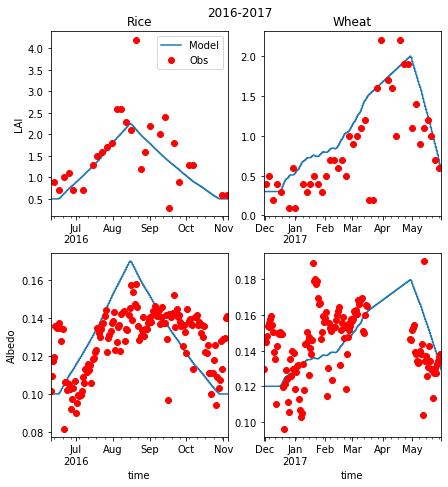

In [36]:
fig,axs=plt.subplots(2,2,figsize=(7,7))
plt.subplots_adjust(hspace=0.2)
fig.suptitle(str(year)+'-'+str(year+1))
fig.subplots_adjust(top=0.93)


ax=axs[0][0]
df_output1.loc[grid].SUEWS.LAI.resample('1h').mean().plot(ax=ax)
lai_obs1.plot(linestyle='',marker='o',color='r',ax=ax,legend=False)
ax.set_ylabel('LAI')
ax.set_title('Rice')
ax.set_xlabel('')

ax=axs[1][0]
df_output1.loc[grid].SUEWS.AlbBulk.resample('1h').mean().plot(ax=ax)
albedo1.plot(marker='o',color='r',linestyle='',ax=ax)
ax.set_ylabel('Albedo')


ax=axs[0][1]
df_output2.loc[grid].SUEWS.LAI.resample('1h').mean().plot(ax=ax)
lai_obs2.plot(linestyle='',marker='o',color='r',ax=ax,legend=False)
ax.set_title('Wheat')
ax.set_xlabel('')

ax=axs[1][1]
df_output2.loc[grid].SUEWS.AlbBulk.resample('1h').mean().plot(ax=ax)
albedo2.plot(marker='o',color='r',linestyle='',ax=ax)

ax=axs[0][0]

ax.legend(['Model','Obs'])

plt.savefig('figs/all_Crop-'+str(year)+'.png',dpi=300,bbox_inches = 'tight',pad_inches = 0.01)

# Reading Forcing

In [37]:
from gs_util import cal_gs_obs,cal_gs_mod
def forcing(year,name,lai):
    if year==2014:
        date2=datetime.datetime(2014,11,30)
        date2_0=datetime.datetime(2014,12,15)
        date2_1=datetime.datetime(2015,5,1)
        date2_2=datetime.datetime(2015,4,16)
        date2_3=datetime.datetime(2015,5,31)

        date1=datetime.datetime(2014,6,10)
        date1_0=datetime.datetime(2014,6,21)
        date1_1=datetime.datetime(2014,8,5)
        date1_2=datetime.datetime(2014,10,1)
        date1_3=datetime.datetime(2014,11,9)
    
    elif year==2015:
        date2=datetime.datetime(2015,11,30)
        date2_0=datetime.datetime(2015,12,10)
        date2_1=datetime.datetime(2016,5,1)
        date2_2=datetime.datetime(2016,4,17)
        date2_3=datetime.datetime(2016,5,25)

        date1=datetime.datetime(2015,6,10)
        date1_0=datetime.datetime(2015,6,20)    
        date1_1=datetime.datetime(2015,8,10)
        date1_2=datetime.datetime(2015,10,2)
        date1_3=datetime.datetime(2015,11,7)

    elif year==2016:
        date2=datetime.datetime(2016,11,30)
        date2_0=datetime.datetime(2016,12,14)
        date2_1=datetime.datetime(2017,5,1)
        date2_2=datetime.datetime(2017,4,15)
        date2_3=datetime.datetime(2017,5,31)

        date1=datetime.datetime(2016,6,10)
        date1_0=datetime.datetime(2016,6,16)
        date1_1=datetime.datetime(2016,8,6)
        date1_2=datetime.datetime(2016,10,1)
        date1_3=datetime.datetime(2016,11,5)
    
    copyfile("./runs/data/" + 'crop' + "_" + 'all' + "_data_60.txt",
             "runs/run/input/Kc_2012_data_60.txt")
    df_forcing = pd.read_csv('runs/run' + '/Input/' + 'kc' + '_' + '2012' +
                             '_data_60.txt',
                             sep=' ',
                             parse_dates={'datetime': [0, 1, 2, 3]},
                             keep_date_col=True,
                             date_parser=func_parse_date)

    all_sites_info = pd.read_csv('site_info.csv')
    site_info = all_sites_info[all_sites_info['Site Id'] == name]
    df = pd.DataFrame({
        'Site': [name],
        'Latitude': [site_info['Latitude (degrees)']],
        'Longitude': [site_info['Longitude (degrees)']]
    })

    path_runcontrol = Path('runs/run' + '/') / 'RunControl.nml'
    df_state_init = sp.init_supy(path_runcontrol)


    grid = df_state_init.index[0]
    df_forcing_run = sp.load_forcing_grid(path_runcontrol, grid)

    if name=='cropr':
        d1=date1
        d2=date1_3
    elif name=='cropw':
        d1=date2
        d2=date2_3        


    df_forcing_run_2=df_forcing_run.loc[d1:d2]
    lai_sub=lai.loc[d1:d2]
    lai_sub.index=[x+datetime.timedelta(hours=12) for x in lai_sub.index]
    a=df_forcing_run_2.loc[lai_sub.index].dropna()
    df_forcing_run_2.loc[a.index,'lai']=lai_sub.loc[a.index]
    df_forcing_run_2.loc[~df_forcing_run_2.index.isin(a.index),'lai']=np.nan
    df_forcing_run_2.lai=df_forcing_run_2.lai.interpolate(limit_direction='both')


    df_state_init ,level= modify_attr(df_state_init, df, name)
    df_state_init.loc[:,'laicalcyes']=0
    mi=df_state_init.loc[:,'laimin'].values[0][2]
    ma=df_state_init.loc[:,'laimax'].values[0][2]
    df_state_init.loc[:,'laimin']=[mi,mi,mi]
    df_state_init.loc[:,'laimax']=[ma,ma,ma]
    
    return df_forcing_run_2,df_state_init,grid,d1,d2

# Calculating OHM coefficients

In [38]:
def calc_OHM(df_obs):
    df_obs=df_obs.replace(-999,np.nan)
    QS_obs=df_obs.qn-df_obs.qe-df_obs.qe
    QS_obs=QS_obs[QS_obs>-200]


    QSTAR=df_obs.loc[QS_obs.index].qn
    all_df=pd.DataFrame()
    all_df['QSTAR']=QSTAR
    all_df['total_time']=(QSTAR.index-datetime.datetime(1970,1,1)).total_seconds()
    all_df=all_df.resample('T').interpolate().resample('1h').mean()



    diff=all_df.diff()
    diff.iloc[0]=diff.iloc[1]
    diff=diff.loc[QS_obs.index]
    dQSTARdt=diff.QSTAR/diff.total_time


    df=pd.DataFrame()
    df['QSTAR']=QSTAR
    df['dQSTARdt']=dQSTARdt*3600
    df['x0']=1

    X=df.values
    y=QS_obs

    coef=np.linalg.lstsq(np.vstack([X[:,0],X[:,1],X[:,2]]).T, y.values)[0]
    return coef,X,QS_obs

In [39]:
year=2015
name='cropr'
lai,gdd_rice=cal_all_lai_model(year)
df_forcing_run_2,df_state_init,grid,d1,d2=forcing(year,name,lai)
df_obs=pd.read_csv('runs/run'+'/Input/'+'kc'+'_2012_data_60.txt',sep=' ',
                                parse_dates={'datetime': [0, 1, 2, 3]},
                                keep_date_col=True,
                                date_parser=func_parse_date)
df_obs=df_obs.set_index('datetime')
df_obs=df_obs.loc[d1:d2]

coef,X,QS_obs=calc_OHM(df_obs)

2020-02-06 14:51:14,022 — SuPy — INFO — All cache cleared.
2020-02-06 14:51:14,831 — SuPy — INFO — All cache cleared.


this coeffcients need to be adjusted later on to get the best QS results

# gs coefficients

In [40]:
year=2015
name='cropr'
lai,gdd_rice=cal_all_lai_model(year)
df_forcing_run_2,df_state_init,grid,d1,d2=forcing(year,name,lai)

2020-02-06 14:51:37,571 — SuPy — INFO — All cache cleared.
2020-02-06 14:51:38,639 — SuPy — INFO — All cache cleared.


## Irrigation modifications

In [41]:
def irr_mod(df_state_init,df_forcing_run_2,year):
    df_state_init.loc[:,'surfacearea']=1
    df_state_init.loc[:,'waterusemethod']=1
    df_state_init.loc[:,'irrfracgrass']=1
    df_state_init.loc[:,'statelimit']=[0.48,0.25,1.3,0.8,   150  ,1.0,30000.0]
    df_state_init.loc[:,'wetthresh']=[0.48,0.25,1.3,0.8,   150  ,1.0,0.5]
    df_forcing_run_2.Wuh=0
    temp=df_forcing_run_2[df_forcing_run_2.index.hour>=22]
    df_forcing_run_2.loc[temp.index,'Wuh']=(1*10000)*(15/100)
    df_forcing_run_2.loc[str(year)+' 10 7':,'Wuh']=0
    return df_state_init,df_forcing_run_2
df_state_init,df_forcing_run_2=irr_mod(df_state_init,df_forcing_run_2,year)

In [42]:
path_runcontrol = Path('runs/run'+'/') / 'RunControl.nml'
df_state_init.loc[:,'soilstore_id']=[50,50,50,50,50,50,0]



error=10
for i in range(10):
    
    if (error <= 0.1):
        break
    df_output, df_state_final = sp.run_supy(df_forcing_run_2, df_state_init, save_state=False)
    final_state = df_state_final[df_state_init.columns.levels[0]].iloc[1]
    df_state_init.iloc[0] = final_state
    soilstore_before = df_state_final.soilstore_id.iloc[0]
    soilstore_after = df_state_final.soilstore_id.iloc[1]
    diff_soil = sum(abs(soilstore_after-soilstore_before))
    error = 100*diff_soil/soilstore_before.mean()
    print(error)


2020-02-06 14:51:45,537 — SuPy — INFO — ====================
2020-02-06 14:51:45,539 — SuPy — INFO — Simulation period:
2020-02-06 14:51:45,540 — SuPy — INFO —   Start: 2015-06-10 00:00:00
2020-02-06 14:51:45,543 — SuPy — INFO —   End: 2015-11-07 00:00:00
2020-02-06 14:51:45,545 — SuPy — INFO — 
2020-02-06 14:51:45,547 — SuPy — INFO — No. of grids: 1
2020-02-06 14:51:45,549 — SuPy — INFO — SuPy is running in serial mode
2020-02-06 14:51:54,513 — SuPy — INFO — Execution time: 9.0 s
2020-02-06 14:51:54,514 — SuPy — INFO — ====================

471.0569267621031
2020-02-06 14:51:54,963 — SuPy — INFO — ====================
2020-02-06 14:51:54,964 — SuPy — INFO — Simulation period:
2020-02-06 14:51:54,965 — SuPy — INFO —   Start: 2015-06-10 00:00:00
2020-02-06 14:51:54,966 — SuPy — INFO —   End: 2015-11-07 00:00:00
2020-02-06 14:51:54,969 — SuPy — INFO — 
2020-02-06 14:51:54,972 — SuPy — INFO — No. of grids: 1
2020-02-06 14:51:54,974 — SuPy — INFO — SuPy is running in serial mode
2020-02-06

## Some necessary functions for gs calculations

In [43]:
from atmosp import calculate as ac
def cal_des_dta(ta, pa, dta=1.0):
    """Calculate slope of es(Ta), i.e., saturation evaporation pressure `es` as function of air temperature `ta [K]`
    Parameters
    ----------
    ta : numeric
        Air temperature [K]
    pa : numeric
        Air pressure [Pa]
    dta : float, optional
        change in ta for calculating that in es, by default 1.0 K
    """

    des = ac('es', p=pa, T=ta + dta/2) - ac('es', p=pa, T=ta - dta/2)
    des_dta = des/dta
    try:
        # try to pack as Series
        des_dta = pd.Series(des_dta, index=ta.index)
    except AttributeError as ex:
        print(ex, 'cannot pack into pd.Series')
        pass
    return des_dta


def cal_rs_obs(qh, qe, ta, rh, pa,RA):
    """Calculate surface resistance based on observations, notably turbulent fluxes.
    Parameters
    ----------
    qh : numeric
        sensible heat flux [W m-2]
    qe : numeric
        latent heat flux [W m-2]
    ta : numeric
        air temperature [K]
    rh : numeric
        relative humidity [%]
    pa : numeric
        air pressure [Pa]
    Returns
    -------
    numeric
        Surface resistance based on observations [s m-1]
    """

    # surface resistance at water surface [s m-1]
    #rav = 100
    rav=RA

    # psychrometric constant [Pa K-1] as a function of air pressure
    ser_gamma = 0.665e-3 * pa

    # air density [kg m-3]
    val_rho = 1.27

    # heat capacity of air [J kg-1 K-1]
    val_cp = 1005

    # slope of es(Ta) curve at Ta
    ser_des_dTa = cal_des_dta(ta, pa, dta=1.0)
    #
    arr_e = ac('e', p=pa, T=ta, RH=rh)
    arr_es = ac('es', p=pa, T=ta)
    arr_vpd = arr_es-arr_e
    #
    ser_rs_1 = ((ser_des_dTa / ser_gamma)*(qh / qe) - 1) * rav
    ser_rs_2 = (val_rho * val_cp * arr_vpd / (ser_gamma * qe))
    ser_rs = ser_rs_1 + ser_rs_2

    try:
        # try to pack as Series
        ser_rs = pd.Series(ser_rs, index=ta.index)
    except AttributeError as ex:
        print(ex, 'cannot pack into pd.Series')
        pass

    return ser_rs,ser_rs_1,ser_rs_2,ser_des_dTa,((ser_des_dTa / ser_gamma)*(qh / qe) - 1),arr_vpd 







def cal_gs_obs(qh, qe, ta, rh, pa,RA):
    """Calculate surface conductance based on observations, notably turbulent fluxes.
    Parameters
    ----------
    qh : numeric
        Sensible heat flux [W m-2]
    qe : numeric
        Latent heat flux [W m-2]
    ta : numeric
        Air temperature [K]
    rh : numeric
        Relative humidity [%]
    pa : numeric
        Air pressure [Pa]
    Returns
    -------
    numeric
        Surface conductance based on observations [mm s-1]
    """
    rs_obs,ser_rs_1,ser_rs_2,ser_des_dTa,br,arr_vpd = cal_rs_obs(qh, qe, ta, rh, pa,RA)
    gs_obs = 1e3/rs_obs
    return gs_obs,ser_rs_1,ser_rs_2,ser_des_dTa,br,arr_vpd

In [44]:
df=df_output.SUEWS.loc[grid,:]
df=df.resample('1h',closed='left',label='right').mean()


df_forcing=pd.read_csv('runs/run'+'/Input/'+'kc'+'_'+'2012'+'_data_60.txt',sep=' ',
                                    parse_dates={'datetime': [0, 1, 2, 3]},
                                    keep_date_col=True,
                                    date_parser=func_parse_date)

df_forcing= df_forcing.set_index('datetime')
df_forcing=df_forcing.loc[d1:d2]

calculate the mimimum and maximum limit for calibrations

In [45]:
g6max=5.56/df.SMD.max()
g6max

0.11395321211431009

In [46]:
g6min=5.56/150
g6min

0.037066666666666664

In [47]:
df_forcing.xsmd=df.SMD
df_forcing.lai=df.LAI
df_forcing = df_forcing[(df_forcing.qe > 0)&(df_forcing.qe < 900)]
df_forcing = df_forcing[df_forcing.qh > 0]
df_forcing = df_forcing[df_forcing.kdown > 5]
df_forcing = df_forcing[df_forcing.Tair > -20]
df_forcing.pres *= 1000
df_forcing.Tair += 273.15
gs_obs,ser_rs_1,ser_rs_2,ser_des_dTa,br,vpd = cal_gs_obs(df_forcing.qh, df_forcing.qe, df_forcing.Tair,
                        df_forcing.RH, df_forcing.pres,df.RA)

df_forcing=df_forcing[gs_obs>0]
gs_obs=gs_obs[gs_obs>0]
df_forcing=df_forcing.replace(-999,np.nan)

In [48]:
g_max=np.percentile(gs_obs,99)
s1=5.56
g_max

403.9804359891874

In [49]:
df_forcing=df_forcing[gs_obs<g_max]
lai_max=df_state_init.laimax.loc[grid,:][2]
gs_obs=gs_obs[gs_obs<g_max]

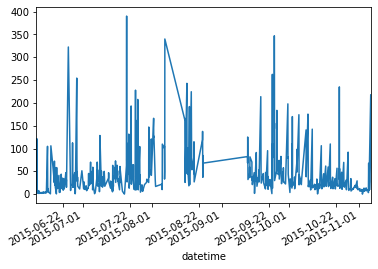

In [50]:
gs_obs.plot()

In [51]:
lai_max

2.25

## Optimization part

More info in [here](https://platypus.readthedocs.io/en/latest/getting-started.html#)

In [52]:
from lmfit import Model, Parameters, Parameter
import numpy as np
import pandas as pd
from atmosp import calculate as ac
import numpy as np
from scipy.optimize import minimize
from pathlib import Path
import supy as sp
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from platypus.core import *
from platypus.types import *
from platypus.algorithms import *
import random
import pickle
import os

df_forcing_train, df_forcing_test, gs_train, gs_test = train_test_split(df_forcing, gs_obs, test_size=0.6, random_state=42)

In [53]:
kd=df_forcing_train.kdown
ta=df_forcing_train.Tair
rh=df_forcing_train.RH
pa=df_forcing_train.pres
smd=df_forcing_train.xsmd
lai=df_forcing_train.lai

In [54]:
def fun_to_opts(G):
    [g1,g2, g3, g4, g5, g6]=[G[0],G[1],G[2],G[3],G[4],G[5]]
    gs_model,g_lai,g_kd,g_dq,g_ta,g_smd,g_z=cal_gs_mod(kd, ta, rh, pa, smd, lai,
                          [g1, g2, g3, g4, g5, g6],
                          g_max, lai_max, s1)
    gs_obs=gs_train
    o1=abs(1-np.std(gs_model)/np.std(gs_obs)) # normilized std difference
    o2=np.mean(abs(gs_model-gs_obs))/(np.mean(gs_obs))
    return [o1,o2],[gs_model.min()]

In [55]:
problem = Problem(6,2,1)
problem.types[0] = Real(.1, .5)
problem.types[1] = Real(100, 500)
problem.types[2] = Real(0, 1)
problem.types[3] = Real(0.4, 1)
problem.types[4] = Real(25, 55)
problem.types[5] = Real(g6min, 0.05)

problem.constraints[0] = ">=0"

problem.function = fun_to_opts
random.seed(12345)
algorithm=CMAES(problem, epsilons=[0.005])
#algorithm=NSGAIII(problem, divisions_outer=12)
algorithm.run(3000)


In [56]:
print( " Obj1\t Obj2")

for solution in algorithm.result[:10]:
    print ("%0.3f\t%0.3f" % tuple(solution.objectives))

 Obj1	 Obj2
0.280	1.043
0.259	1.080
0.204	1.184
0.505	0.688
0.438	0.778
0.385	0.857
0.158	1.272
0.435	0.783
0.350	0.917
0.458	0.749


Text(0, 0.5, 'objective 2')

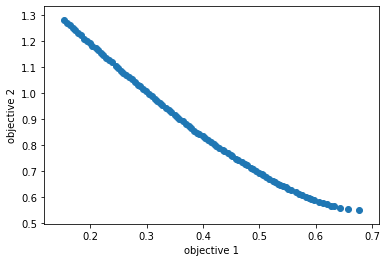

In [57]:
f, ax = plt.subplots(1, 1)
plt.scatter([s.objectives[0] for s in algorithm.result],
           [s.objectives[1] for s in algorithm.result])
plt.xlabel('objective 1')
plt.ylabel('objective 2')

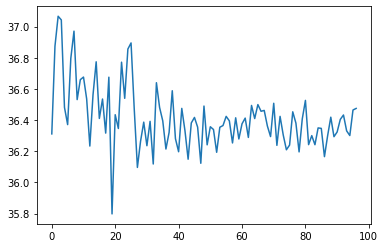

In [58]:
all_G={
      'g2':[],
      'g3':[],
      'g4':[],
      'g5':[],
      'g6':[]
      }
for s in algorithm.result:
        all_G['g2'].append(s.variables[0])
        all_G['g3'].append(s.variables[1])
        all_G['g4'].append(s.variables[2])
        all_G['g5'].append(s.variables[3])
        all_G['g6'].append(s.variables[4])
plt.plot(all_G['g6'])

In [59]:
all_std=[s.objectives[0] for s in algorithm.result]
all_MAE=[s.objectives[1] for s in algorithm.result]
all_std=np.array(all_std)
all_MAE=np.array(all_MAE)

In [60]:
method='median' # 'obj1' or 'obj2' or 'median'
colors= ['b','g','r','y']

if method == 'median':
    idx_med=np.where(all_MAE==all_MAE[(all_std<=np.median(all_std))].min())[0][0]
elif method == 'obj1':
    idx_med=np.where(all_MAE==all_MAE[(all_std>=np.min(all_std))].max())[0][0]
elif method == 'obj2':
    idx_med=np.where(all_MAE==all_MAE[(all_std<=np.max(all_std))].min())[0][0]
print(all_std[idx_med])
print(all_MAE[idx_med])


0.3939428788053452
0.841865303541144


In [61]:
[g1,g2,g3,g4,g5,g6] = algorithm.result[idx_med].variables

In [62]:
with open('outputs/g1-g6/'+name+'-g1-g6.pkl','wb') as f:
    pickle.dump([g1,g2,g3,g4,g5,g6], f)

In [63]:
with open('outputs/g1-g6/'+name+'-g1-g6.pkl','rb') as f:
    [g1,g2,g3,g4,g5,g6]=pickle.load(f)

In [64]:

pd.DataFrame([np.round([g1,g2,g3,g4,g5,g6],3)],columns=['g1','g2','g3','g4','g5','g6'],index=[name])

,g1,g2,g3,g4,g5,g6
cropr,0.358,104.778,0.685,0.797,36.392,0.05


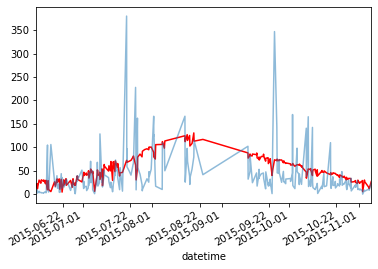

In [65]:
gs_model,g_lai,g_kd,g_dq,g_ta,g_smd,g_max=cal_gs_mod(kd, ta, rh, pa, smd, lai,
                          [g1, g2, g3, g4, g5, g6],
                          g_max, lai_max, s1)

gs_model.plot(color='r')
gs_train.plot(alpha=0.5)

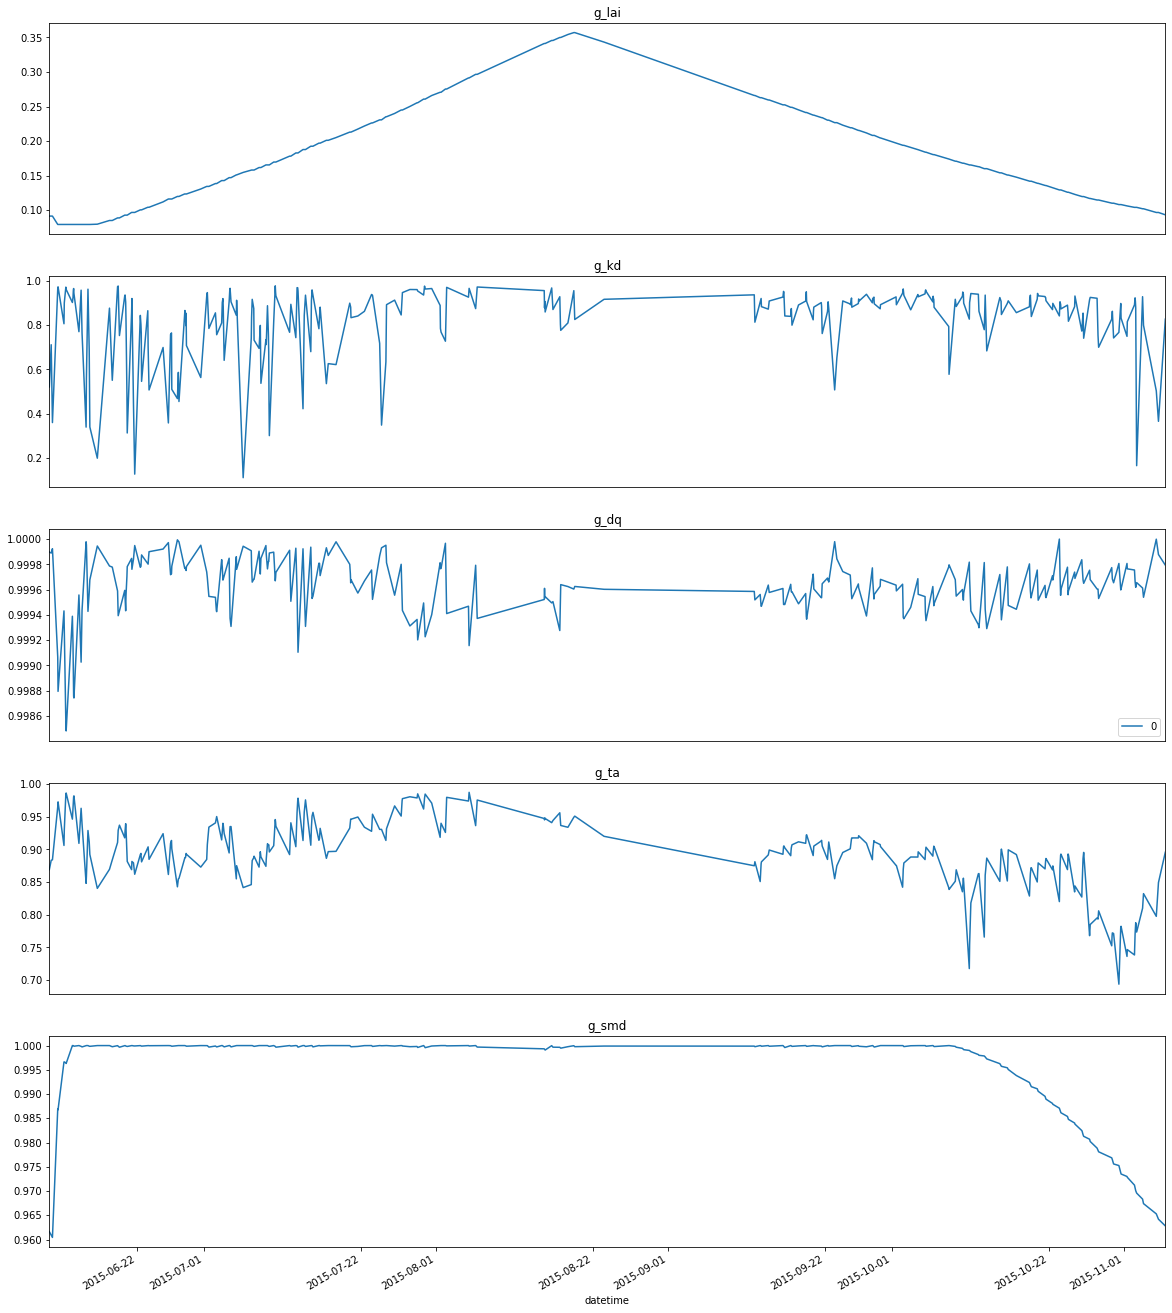

In [66]:
g_dq=pd.DataFrame(g_dq,index=g_lai.index)
fig,axs=plt.subplots(5,1,figsize=(20,25))
a={'0':g_lai,'1':g_kd,'2':g_dq,'3':g_ta,'4':g_smd}
b={'0':'g_lai','1':'g_kd','2':'g_dq','3':'g_ta','4':'g_smd'}
for i in range(0,5):
    ax=axs[i]
    a[str(i)].plot(ax=ax)
    ax.set_title(b[str(i)])
    if i!=4:
        ax.set_xticks([''])
        ax.set_xlabel('')
    
    

# Testing after calibration of all parameters

In [67]:
from gs_util import IQR_compare,obs_sim

def modify_attr_2(df_state_init,g_max,s1):
    df_state_init.maxconductance=g_max
    df_state_init.s1=s1
    return df_state_init

def gs_plot_test(tp,coef,lai,d1,d2,d3,g1,g2,g3,g4,g5,g6,g_max,s1,name,year,alpha=1):

    all_sites_info = pd.read_csv('site_info.csv')
    site_info = all_sites_info[all_sites_info['Site Id'] == name]
    df = pd.DataFrame({
        'Site': [name],
        'Latitude': [site_info['Latitude (degrees)']],
        'Longitude': [site_info['Longitude (degrees)']]
    })    
    
    path_runcontrol = Path('runs/run'+'/') / 'RunControl.nml'
    df_state_init = sp.init_supy(path_runcontrol)
    grid = df_state_init.index[0]
    df_forcing_run = sp.load_forcing_grid(path_runcontrol, grid)
    
    df_state_init,df_forcing_run=irr_mod(df_state_init,df_forcing_run,year)
    
    a=df_state_init.loc[:,'ohm_coef'].values[0]
    for i in [0,1,2,3]:
        s=4
        a[(s)*4*3+((i)*3)+(0)]=coef[0]
        a[(s)*4*3+((i)*3)+(1)]=coef[1]
        a[(s)*4*3+((i)*3)+(2)]=coef[2]

    df_state_init.loc[:,'ohm_coef']=a
    
    
    df_forcing_run_2=df_forcing_run.loc[d1:d2]
    lai_sub=lai.loc[d1:d2]
    lai_sub.index=[x+datetime.timedelta(hours=12) for x in lai_sub.index]
    a=df_forcing_run_2.loc[lai_sub.index].dropna()
    
    df_forcing_run_2.loc[a.index,'lai']=lai_sub.loc[a.index]
    df_forcing_run_2.loc[~df_forcing_run_2.index.isin(a.index),'lai']=np.nan
    df_forcing_run_2.lai=df_forcing_run_2.lai.interpolate(limit_direction='both')
    
    
    df_forcing_run_2.qn=sp.util.fill_gap_all(df_forcing_run_2.qn.replace(-999,np.nan))

    df_state_init ,level= modify_attr(df_state_init, df, name)
    df_state_init.loc[:,'laicalcyes']=0
    mi=df_state_init.loc[:,'laimin'].values[0][2]
    ma=df_state_init.loc[:,'laimax'].values[0][2]
    df_state_init.loc[:,'laimin']=[mi,mi,mi]
    df_state_init.loc[:,'laimax']=[ma,ma,ma]    
    

    df_state_init.g1=g1*alpha
    df_state_init.g2=g2
    df_state_init.g3=g3
    df_state_init.g4=g4
    df_state_init.g5=g5
    df_state_init.g6=g6
    df_state_init.loc[:,'netradiationmethod']=0

    
    df_state_init=modify_attr_2(df_state_init,g_max,s1)
    
    if tp=='soil':
        df_forcing_run_2=df_forcing_run_2.loc[d1:d3]
        df_state_init.lai_id = 2.5
    else:
        df_forcing_run_2=df_forcing_run_2.loc[d3:d2]
    
    df_output, df_state_final = sp.run_supy(df_forcing_run_2, df_state_init, save_state=False)


    df_obs=pd.read_csv('runs/run'+'/Input/'+'kc'+'_2012_data_60.txt',sep=' ',
                                    parse_dates={'datetime': [0, 1, 2, 3]},
                                    keep_date_col=True,
                                    date_parser=func_parse_date)

    df_obs= df_obs.set_index('datetime')
    df_obs=df_obs.loc[d1:d2]
    df_obs=df_obs[df_obs.rain==0]


    ax=axs[0]
    df_obs_temp=df_obs.replace(-999,np.nan)
    
    df=df_output.SUEWS.loc[grid,:]
    df=df.resample('1h',closed='left',label='right').mean()
    


        
    return df_obs,df_output, df_state_init,df_forcing_run_2

In [68]:
g_max=419.45872285126813
s1=5.56
alpha=1.8 # need to be tuned iteratively
coef=[0.18500347863999997, 0.6152151645, -18] # adjusted based on the the regression at top to fit a better line to QS

## running the model

In [69]:
year=2015
name='cropr'
w='wo' # radiation method
tp='veg' # vegetation or soil


if year==2014:
    date2=datetime.datetime(2014,11,30)
    date2_0=datetime.datetime(2014,12,15)
    date2_1=datetime.datetime(2015,5,1)
    date2_2=datetime.datetime(2015,4,16)
    date2_3=datetime.datetime(2015,5,31)

    date1=datetime.datetime(2014,6,10)
    date1_0=datetime.datetime(2014,6,21)
    date1_1=datetime.datetime(2014,8,5)
    date1_2=datetime.datetime(2014,10,1)
    date1_3=datetime.datetime(2014,11,9)
    
    date4=datetime.datetime(2014,7,1)
    

elif year==2015:
    date2=datetime.datetime(2015,11,30)
    date2_0=datetime.datetime(2015,12,10)
    date2_1=datetime.datetime(2016,5,1)
    date2_2=datetime.datetime(2016,4,17)
    date2_3=datetime.datetime(2016,5,25)

    date1=datetime.datetime(2015,6,10)
    date1_0=datetime.datetime(2015,6,20)    
    date1_1=datetime.datetime(2015,8,10)
    date1_2=datetime.datetime(2015,10,2)
    date1_3=datetime.datetime(2015,11,7)
    
    date4=datetime.datetime(2015,7,1)

elif year==2016:
    date2=datetime.datetime(2016,11,30)
    date2_0=datetime.datetime(2016,12,14)
    date2_1=datetime.datetime(2017,5,1)
    date2_2=datetime.datetime(2017,4,15)
    date2_3=datetime.datetime(2017,5,31)

    date1=datetime.datetime(2016,6,10)
    date1_0=datetime.datetime(2016,6,16)
    date1_1=datetime.datetime(2016,8,6)
    date1_2=datetime.datetime(2016,10,1)
    date1_3=datetime.datetime(2016,11,5)
    
    date4=datetime.datetime(2016,7,1)
    

lai,gdd_rice=cal_all_lai_model(year)
df_forcing_run_2,df_state_init,grid,d1,d2=forcing(year,name,lai)

d3=date4
df_obs,df_output, df_state_init,df_forcing_run_2=gs_plot_test(tp,coef,lai,d1,d2,d3,g1,g2,g3,g4,g5,g6,g_max,s1,name,year,alpha)

2020-02-06 14:55:09,048 — SuPy — INFO — All cache cleared.
2020-02-06 14:55:10,802 — SuPy — INFO — All cache cleared.
2020-02-06 14:55:17,618 — SuPy — INFO — All cache cleared.
2020-02-06 14:55:18,717 — SuPy — INFO — All cache cleared.
2020-02-06 14:55:28,248 — SuPy — INFO — ====================
2020-02-06 14:55:28,252 — SuPy — INFO — Simulation period:
2020-02-06 14:55:28,256 — SuPy — INFO —   Start: 2015-07-01 00:00:00
2020-02-06 14:55:28,265 — SuPy — INFO —   End: 2015-11-07 00:00:00
2020-02-06 14:55:28,271 — SuPy — INFO — 
2020-02-06 14:55:28,274 — SuPy — INFO — No. of grids: 1
2020-02-06 14:55:28,276 — SuPy — INFO — SuPy is running in serial mode
2020-02-06 14:55:41,028 — SuPy — INFO — Execution time: 12.8 s
2020-02-06 14:55:41,029 — SuPy — INFO — ====================



 we need to exclude the data related to rainfall that gives abnormal values of QE

In [70]:
df_obs=df_obs[df_obs.rain==0]
df_mod=df_output.SUEWS.QE.loc[grid,:].resample('1h',closed='left',label='right').mean()
qe_obs=df_obs[(df_obs.qe>0)&(df_obs.qe<900)].qe
qe_mod=df_mod.loc[qe_obs.index].dropna()
diff_qe=(qe_obs-qe_mod)
abnorm=diff_qe[diff_qe>250]
abnorm=abnorm[qe_mod[abnorm.index]<100]

df_obs=df_obs[~df_obs.index.isin(abnorm.index)]

df_obs=df_obs[df_obs.rain==0]
df_obs=df_obs.replace(-999,np.nan)
df_obs=df_obs[df_obs.qe<800]
df_obs=df_obs[df_obs.qh>-500]
df_all= df_obs
df_an=df_all.loc[d3:d2]

df_an.index=pd.to_datetime(df_an.index)
df_an=df_an

out=df_output.SUEWS.loc[grid]

out=out.loc[d3:d2]


out=out.resample('1h',closed='left',label='right').mean()

df_an['qs']=df_an.qn-df_an.qe-df_an.qh
df_an=df_an[df_an.qs>-300]


# Plotting the results

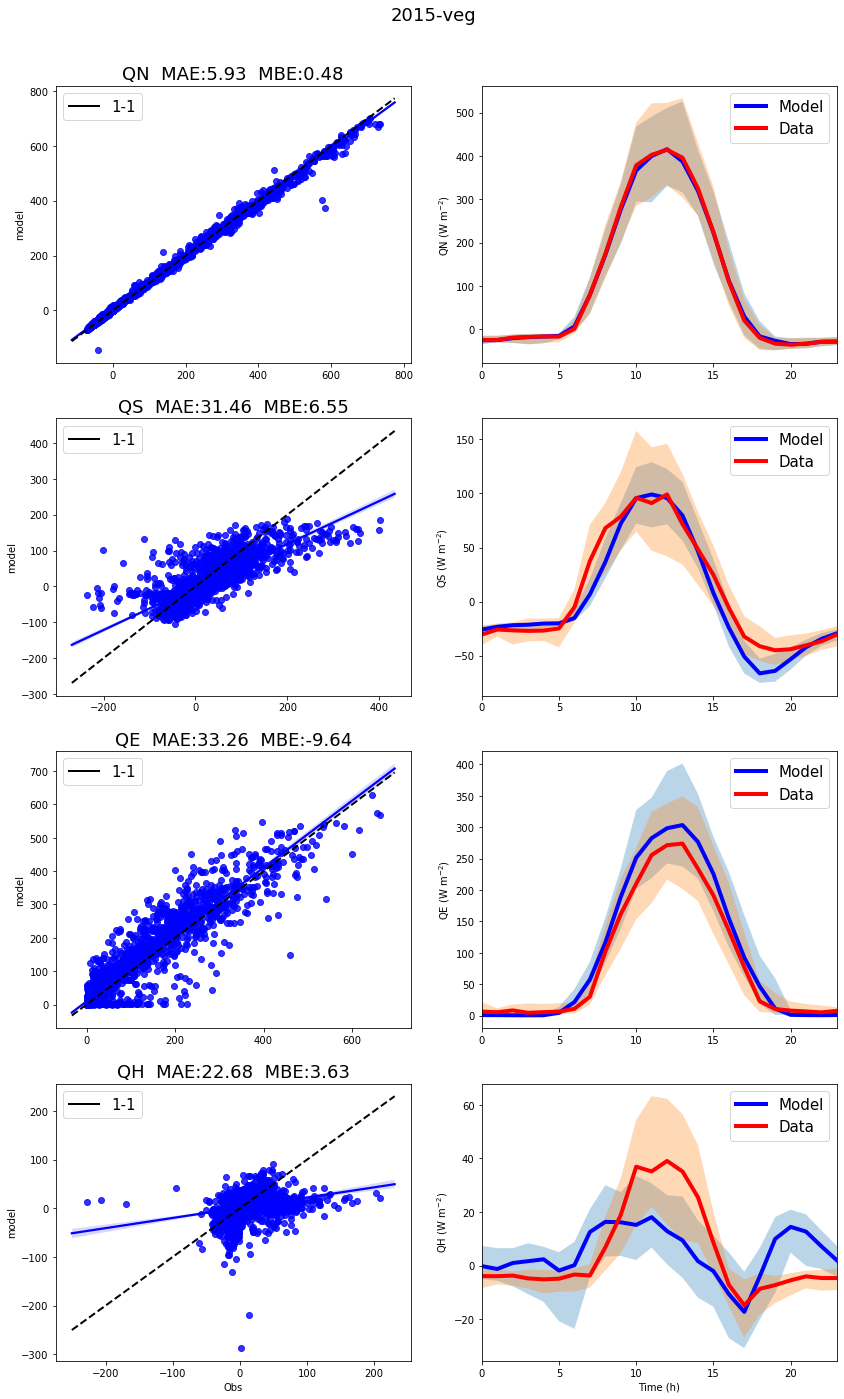

In [71]:

var_meas=['qn','qs','qe','qh']
var_model=['QN','QS','QE','QH']

fig,axs=plt.subplots(len(var_meas),2,figsize=(14,22))
plt.rc('font', size=15)
fig.suptitle(str(year)+'-'+tp)
fig.subplots_adjust(top=0.93)

counter=-1
for varmeas,varmodel in zip(var_meas,var_model):
    counter=counter+1
    
    meas=df_an[varmeas].dropna()
    

    ax=axs[counter][0]
    temp=df_an.loc[meas.index]
    aa=out.loc[temp.index][varmodel].dropna()
    obs_sim(varmeas,varmodel,temp.loc[aa.index],out.loc[aa.index],ax)
    ax.set_ylabel('model')
    
    MAE=np.round(np.mean(abs(temp.loc[aa.index][varmeas]-out.loc[aa.index][varmodel])),2)
    MBE=np.round(np.mean((temp.loc[aa.index][varmeas]-out.loc[aa.index][varmodel])),2)

    if counter==len(var_model)-1:
        ax.set_xlabel('Obs')
    ax.set_title(varmodel+'  MAE:'+str(MAE)+'  MBE:'+str(MBE))
    
    ax=axs[counter][1]
    IQR_compare(varmeas,varmodel,temp,out.loc[temp.index],ax)
    ax.legend()
    if counter==len(var_model)-1:
        ax.set_xlabel('Time (h)')
    ax.set_ylabel(varmodel+' (W m$^{-2}$)')
# plt.savefig('china-SEB-'+tp+'-'+str(year)+'.png',dpi=300,bbox_inches = 'tight',pad_inches = 0.01)

# writing into Pickle files

In [74]:
with open('outputs/g1-g6/'+name+'-g1-g6.pkl','wb') as f:
    pickle.dump([g_max,alpha,g1,g2,g3,g4,g5,g6], f)



In [75]:
all_data={}
all_data['model']=out.QE
all_data['obs']=df_an.qe
with open('outputs/surface_conductance/'+'crop-rice-DNT-'+str(year)+'.pkl','wb') as f:
    pickle.dump(all_data, f)